Device: cpu
Early stopping at epoch 61
Best SCSO hyperparameters: n_agents=24, sigma=0.02, epochs=12

Test metrics after SCSO + LSTM:
MAE: 13.6962
RMSE: 17.1034
MAPE: 1.496%
Calculated Accuracy: 98.504%


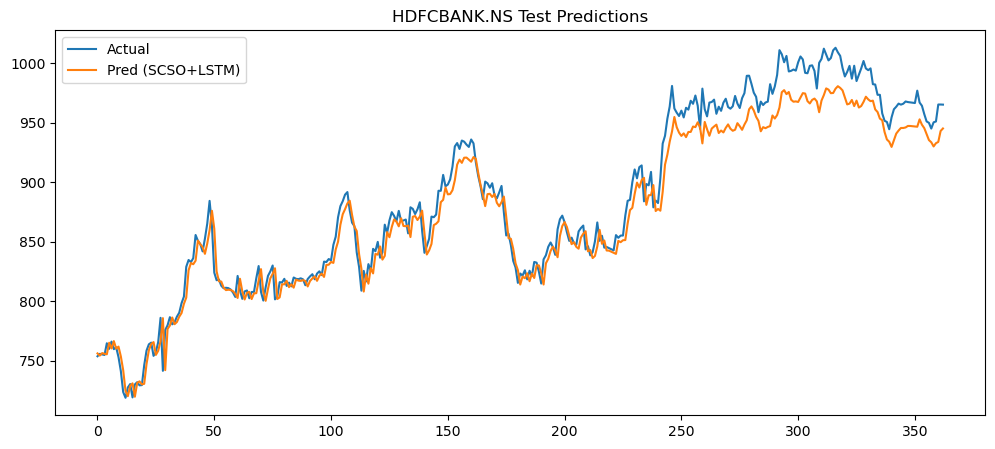

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

In [21]:
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import itertools

# ---------------- reproducibility ----------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ---------------- device ----------------
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# ---------------- data ----------------
data_dir = "../Data"
ticker = 'HDFCBANK.NS'
csv_path = os.path.join(data_dir, f"{ticker}_features.csv")
df = pd.read_csv(csv_path)
df['Date'] = pd.to_datetime(df['Date'])
df.reset_index(drop=True, inplace=True)
data = df[['Date','Close']].copy()

# ---------------- prepare sequences ----------------
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
X = shifted_df.drop('Close', axis=1).values
y = shifted_df['Close'].values

scaler_X = MinMaxScaler(feature_range=(-1,1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(-1,1))
y = scaler_y.fit_transform(y.reshape(-1,1))
X = dc(np.flip(X, axis=1))  # flip to match time order

split_index = int(len(X)*0.7)
X_train_np, X_test_np = X[:split_index], X[split_index:]
y_train_np, y_test_np = y[:split_index], y[split_index:]

X_train = torch.tensor(X_train_np.reshape(-1,lookback,1)).float()
X_test = torch.tensor(X_test_np.reshape(-1,lookback,1)).float()
y_train = torch.tensor(y_train_np).float()
y_test = torch.tensor(y_test_np).float()

# ---------------- dataset ----------------
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,i):
        return self.X[i], self.y[i]

train_loader = DataLoader(TimeSeriesDataset(X_train,y_train),batch_size=16,shuffle=False)
val_loader = DataLoader(TimeSeriesDataset(X_test,y_test),batch_size=16,shuffle=False)

# ---------------- LSTM model ----------------
class LSTMModel(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,num_layers=2,dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size,1)
    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.lstm.num_layers,batch_size,self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers,batch_size,self.lstm.hidden_size).to(device)
        out,_ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

model = LSTMModel(1,64,2,0.2).to(device)
loss_fn = nn.MSELoss()

# ---------------- helper functions ----------------
def evaluate_loss_on_loader(model, loader, loss_fn, device):
    model.eval()
    total_loss=0
    total_samples=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out,yb)
            total_loss += loss.item()*xb.size(0)
            total_samples += xb.size(0)
    return total_loss/max(1,total_samples)

def get_flat_params_from_module(module):
    return torch.cat([p.data.view(-1) for p in module.parameters()]).detach()

def set_flat_params_to_module(module, flat_params):
    idx=0
    for p in module.parameters():
        n = p.numel()
        p.data.copy_(flat_params[idx:idx+n].view_as(p).to(p.device))
        idx+=n

# ---------------- Adam pretraining ----------------
pretrain_epochs = 80
patience = 10
clip_value = 1.0
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5)
best_val = float('inf')
best_state = None
best_state_fc = None
no_improve = 0

for epoch in range(pretrain_epochs):
    model.train()
    running,count=0,0
    for xb,yb in train_loader:
        xb,yb = xb.to(device),yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out,yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),clip_value)
        optimizer.step()
        running += loss.item()*xb.size(0)
        count += xb.size(0)
    train_loss = running/max(1,count)
    val_loss = evaluate_loss_on_loader(model,val_loader,loss_fn,device)
    scheduler.step(val_loss)
    if val_loss<best_val-1e-6:
        best_val=val_loss
        best_state={k:v.cpu().clone() for k,v in model.state_dict().items()}
        best_state_fc={k:v.cpu().clone() for k,v in model.fc.state_dict().items()}
        no_improve=0
    else:
        no_improve+=1
    if no_improve>=patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_state)

# ---------------- SandCatFC (SCSO) ----------------
class SandCatFC:
    def __init__(self,n_agents=20,sigma=0.02,device='cpu',verbose=True):
        self.n_agents=int(n_agents)
        self.sigma=float(sigma)
        self.device=device
        self.verbose=verbose
    def optimize(self,model,train_loader,val_loader,loss_fn,epochs=10):
        module = model.fc
        best_pos = get_flat_params_from_module(module).to(self.device).clone()
        dim = best_pos.numel()
        base_scale = (best_pos.abs()+1.0).to(self.device)
        pop = best_pos.unsqueeze(0).repeat(self.n_agents,1) + \
              (self.sigma*torch.randn(self.n_agents,dim,device=self.device)*base_scale.unsqueeze(0))
        best_score=float('inf')
        for it in range(epochs):
            scores=[]
            for i in range(self.n_agents):
                cand = pop[i]
                set_flat_params_to_module(module,cand)
                train_loss = evaluate_loss_on_loader(model,train_loader,loss_fn,self.device)
                scores.append(train_loss)
            scores = np.array(scores)
            argmin=int(np.argmin(scores))
            if scores[argmin]<best_score:
                best_score=float(scores[argmin])
                best_pos = pop[argmin].clone()
            set_flat_params_to_module(module,best_pos)
            a = 2*(1-(it/max(1,epochs)))
            spread = (self.sigma*(a*0.5+0.01))*base_scale.unsqueeze(0)
            pop = best_pos.unsqueeze(0).repeat(self.n_agents,1)+torch.randn(self.n_agents,dim,device=self.device)*spread
            pop[0]=best_pos.clone()
        set_flat_params_to_module(module,best_pos)
        return best_score

# ---------------- Hyperparameter tuning ----------------
n_agents_list=[12,24]
sigma_list=[0.01,0.02]
sco_epochs_list=[6,12]
best_val_loss=float('inf')
best_hparams=None
best_model_state=None

for n_agents,sigma,epochs in itertools.product(n_agents_list,sigma_list,sco_epochs_list):
    model.fc.load_state_dict(best_state_fc)
    sco=SandCatFC(n_agents=n_agents,sigma=sigma,device=device,verbose=False)
    val_loss = sco.optimize(model,train_loader,val_loader,loss_fn,epochs=epochs)
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        best_hparams=(n_agents,sigma,epochs)
        best_model_state={k:v.cpu().clone() for k,v in model.state_dict().items()}

print(f"Best SCSO hyperparameters: n_agents={best_hparams[0]}, sigma={best_hparams[1]}, epochs={best_hparams[2]}")
model.load_state_dict(best_model_state)

# ---------------- Evaluate on test ----------------
future_preds = []
last_seq = X_test[-1].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    test_pred = model(X_test.to(device)).cpu().numpy()
    test_pred_inv = scaler_y.inverse_transform(test_pred)
    y_test_inv = scaler_y.inverse_transform(y_test.cpu().numpy())

mae_final = mean_absolute_error(y_test_inv.flatten(),test_pred_inv.flatten())
rmse_final = math.sqrt(mean_squared_error(y_test_inv.flatten(),test_pred_inv.flatten()))
mape_final = mean_absolute_percentage_error(y_test_inv.flatten(),test_pred_inv.flatten())*100
acc_final = 100 - mape_final

print("\nTest metrics after SCSO + LSTM:")
print(f"MAE: {mae_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAPE: {mape_final:.3f}%")
print(f"Calculated Accuracy: {acc_final:.3f}%")

# ---------------- Plot test predictions ----------------
plt.figure(figsize=(12,5))
plt.plot(y_test_inv.flatten(),label='Actual')
plt.plot(test_pred_inv.flatten(),label='Pred (SCSO+LSTM)')
plt.title(f"{ticker} Test Predictions")
plt.legend()
plt.show()

# ---------------- Multi-step 10-day Forecast ----------------
forecast_horizon=10
last_seq = X_test[-1].unsqueeze(0).to(device)
future_preds=[]

model.eval()
with torch.no_grad():
    for _ in range(forecast_horizon):
        next_pred = model(last_seq)
        future_preds.append(next_pred.cpu().numpy().flatten()[0])
        next_input = torch.cat([last_seq[:,1:,:], next_pred.unsqueeze(0).unsqueeze(2)],dim=1) # FIXED
        last_seq = next_input

future_preds_inv = scaler_y.inverse_transform(np.array(future_preds).reshape(-1,1))

# ---------------- Plot 10-day forecast ----------------
plt.figure(figsize=(12,5))
plt.plot(np.arange(1,forecast_horizon+1),future_preds_inv,marker='o',label='Predicted')
plt.title(f"{ticker} Next {forecast_horizon}-Day Forecast")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.grid(True,alpha=0.3)
plt.legend()
plt.show()
